In [4]:
import sys
sys.path.append("/media/arjun/SSD/chaos/cache-management")

import matplotlib.pyplot as plt

import seaborn as sns
import sqlite3
import pickle as pkl
import os
import shutil
import csv
import numpy as np
import pysftp
import paramiko

sns.set()

In [5]:
transport = paramiko.Transport(('127.0.0.1',1234))
transport.connect(username='akaruvally', password='arjun23496')
sftp = paramiko.SFTPClient.from_transport(transport)

In [6]:
sftp.get('/mnt/nfs/scratch1/akaruvally/dbs/rkc_analysis.db', 
         '../../../rkc_analysis.db')

In [7]:
# db = sqlite3.connect("../../../rkc_analysis.db")
db=sqlite3.connect("/media/arjun/Shared/cluster/dbs/rkc_analysis_test.db")

In [8]:
rows = db.execute("""
select 
seed, num_params, l0_coefficient, mean_error, error_bound, emp_rad 
from 
results inner join trained_models 
on 
results.experiment_id = trained_models.experiment_id 
where 
trained_models.model_id = 32771
and 
l2_coefficient=0
and
n_samples=1""")

data_mean = {}
data_bound = {}

reg_list_unsorted = set([])

for row in rows:
    if row[2] not in data_mean:
        data_mean[row[2]] = []
        data_bound[row[2]] = []
    
    data_mean[row[2]].append((row[1], row[3]))
    data_bound[row[2]].append((row[1], row[4]))
    reg_list_unsorted.add(row[2])

In [9]:
data_mean

{2.8334: [(442738, 0.0506)],
 0.0176: [(426797, 0.0739)],
 0.0427: [(260738, 0.1395)],
 0.0091: [(399929, 0.1464)],
 6.8532: [(438188, 0.0543)],
 0.0073: [(395699, 0.1797)],
 0.127: [(459165, 0.078)],
 20.7656: [(435134, 0.0585)],
 50.0: [(445030, 0.0511)],
 34.8669: [(434528, 0.0586)],
 2.7958: [(442691, 0.0505)],
 0.7917: [(449637, 0.0483)],
 0.9481: [(448817, 0.0484)],
 4.0093: [(440794, 0.0522)],
 0.109: [(321305, 0.1235)],
 0.015: [(440985, 0.0635)],
 1.3596: [(446951, 0.0493)],
 0.0309: [(228963, 0.1574)],
 75.5102: [(445069, 0.0511)],
 97.9592: [(445008, 0.0511)],
 52.0408: [(445041, 0.0513)],
 96.9388: [(445064, 0.0512)],
 59.1837: [(445087, 0.0513)],
 58.1633: [(445063, 0.0512)]}

In [10]:
reg_list_unsorted = list(reg_list_unsorted)
reg_list = np.sort(reg_list_unsorted)
tmp_directory = "/media/arjun/Shared"

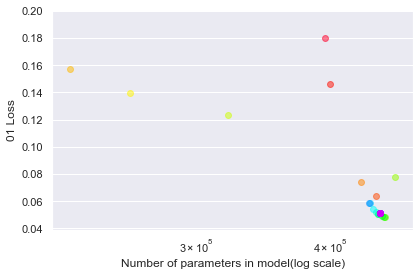

In [11]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = len(reg_list)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for param_idx, key in enumerate(reg_list):
    val = data_mean[key]
    x_list = [ x[0] for x in val ]
    y_list = [ x[1] for x in val ]
    y_bound_list = [ x[1] for x in data_bound[key] ]
    ax.scatter(x_list, y_list, label="l0_reg= {}".format(key), alpha=0.5)
#     ax.scatter(x_list, y_bound_list, color='black')

ax.set_ylabel("01 Loss")
# ax.set_xlim((2.5*10**3, 3*10**4))
ax.set_xlabel("Number of parameters in model(log scale)")
# ax.legend()
ax.set_xscale('log')
# plt.show()
plt.tight_layout()
plt.savefig(os.path.join(tmp_directory, "reg_loss_graph.jpg"), dpi=700)

(1, 24)


No handles with labels found to put in legend.


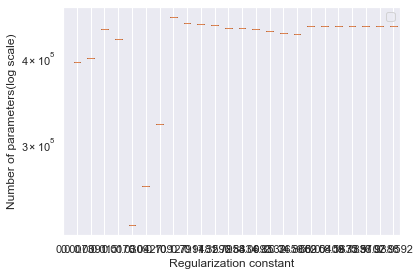

In [12]:
plt.figure(figsize=(6,4))

dataset = []


for key in reg_list:
    val = data_mean[key]
    vals = [ np.sum(x[0]) for x in val ]
    dataset.append(vals)

dataset = np.array(dataset)
dataset = dataset.T
print(dataset.shape)
plt.boxplot(dataset)
    
plt.ylabel("Number of parameters(log scale)")
plt.xticks(ticks=np.arange(len(reg_list)+1), labels=np.insert(reg_list, 0, 0))
plt.xlabel("Regularization constant")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(tmp_directory, "param_reg_graph.jpg"), dpi=700)